# **Classifying drug and vitamin types using MobileNetV2 model with Transfer Learning**

Dataset link : https://www.kaggle.com/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D


from tensorflow.keras.applications import MobileNetV2
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = "Drug Vision/Data Combined"  # the path of the dataset
image_dir = Path(dataset)

filepaths = list(image_dir.glob("**/*.jpg")) + list(image_dir.glob("**/*.png"))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name="filepath").astype("str")
labels = pd.Series(labels, name="label")


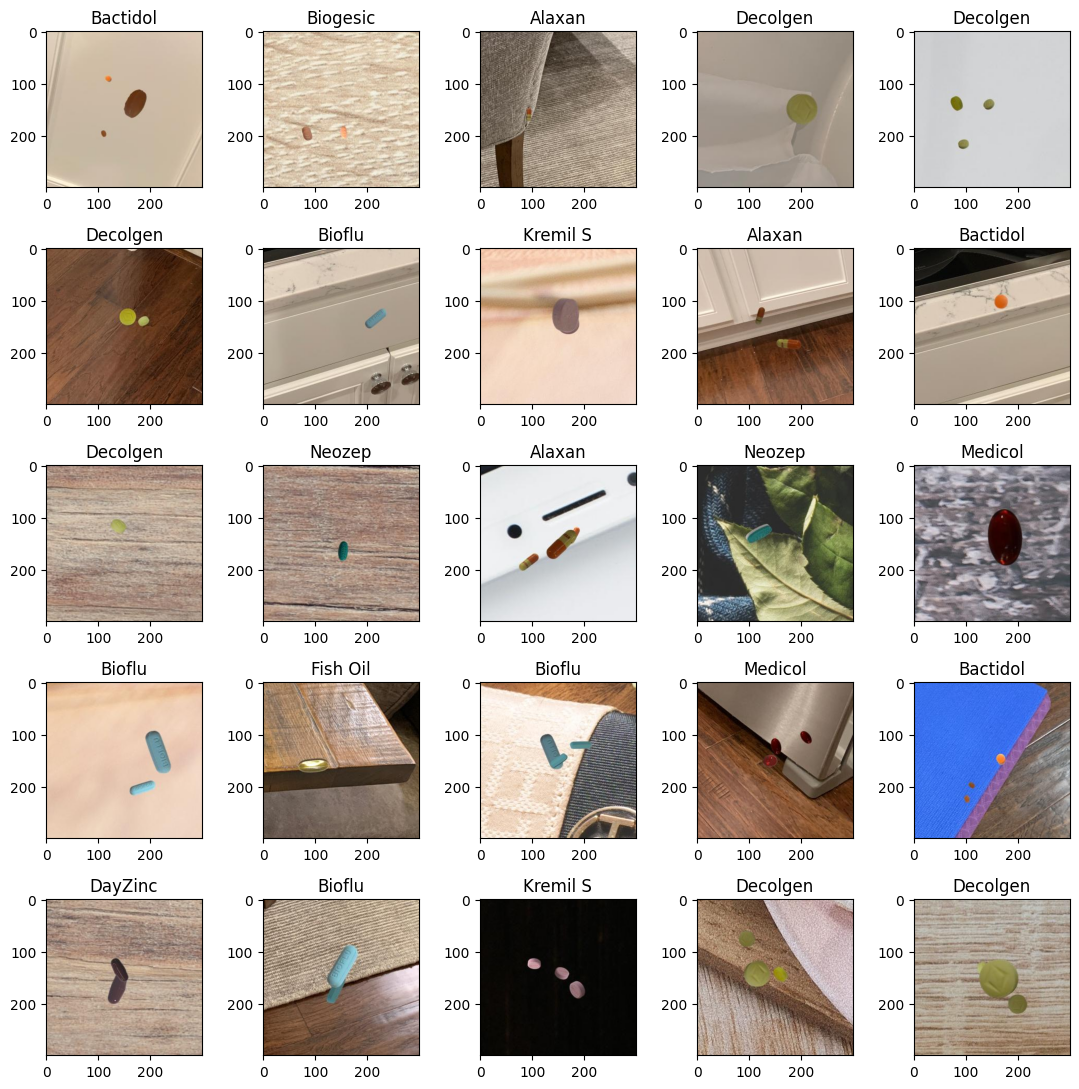

In [3]:
image_df = pd.concat([filepaths, labels], axis=1)

random_index = np.random.randint(0,len(image_df),25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(11,11))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[random_index[i]]))
    ax.set_title(image_df.label[random_index[i]])
plt.tight_layout()


In [4]:
train_df, test_df = train_test_split(image_df, test_size=0.2 ,random_state=42, shuffle=True)

# Data Augmentation 
train_generator = ImageDataGenerator(
                    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                    validation_split= 0.2)

test_generator = ImageDataGenerator(
                        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)


In [5]:
# Streaming training data from dataframe

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col= "filepath",
    y_col= "label",
    target_size= (224,224),
    color_mode="rgb",
    class_mode = "categorical",
    batch_size = 64,
    shuffle=True,
    seed = 42,
    subset= "training"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = "filepath",
    y_col= "label",
    target_size= (224,224),
    color_mode="rgb",
    class_mode = "categorical",
    batch_size = 64,  
    shuffle = True,
    seed = 42,
    subset="validation"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col = "filepath",
    y_col= "label",
    target_size= (224,224),
    color_mode="rgb",
    class_mode = "categorical",
    batch_size = 64, 
    shuffle=False
    
)

# During training, shuffle=True is used to increase data diversity and help prevent overfitting.
# However, during testing: The model's predictions need to be compared with the correct labels in the same order.
# If shuffling is enabled, the predictions and test labels will not match.



Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


Initially setting pretrained_model.trainable = False and later training specific layers (fine-tuning) is done to achieve optimal performance in the transfer learning process while preventing overfitting.

A pretrained model like MobileNetV2 has already learned general visual features from a large dataset (ImageNet). If the entire model is trained from the beginning, the well-learned weights may be unnecessarily altered, leading to overfitting or poor performance.

Therefore, I first train only the newly added dense layers.

At this stage, the previously trained final layers of the model have adapted to the new dataset. Now, by training the last 30 layers, we allow the model to fine-tune deeper features according to the new dataset.

Instead of training all layers, I only fine-tune specific upper layers because:

The initial layers learn fundamental visual features (edges, colors), which do not need modification.
The upper layers learn more abstract features (object shapes, complex details), making fine-tuning beneficial.

In [6]:
pretrained_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top = False, # Not including the Mobile Net Classification layer
    weights = "imagenet", # the data set was it trained on
)

pretrained_model.trainable = False


# Callbacks
checkpoint_path = "best_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only = True,
                                      monitor= "val_accuracy",
                                      save_best_only = True)

early_stopping = EarlyStopping(monitor = "val_accuracy",
                               patience = 5,
                               restore_best_weights = True)

# Building Model while using Pretrained Model (mobilenet-42)
inputs = pretrained_model.input
x = GlobalAveragePooling2D()(pretrained_model.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation="softmax")(x)

model = Model(inputs = inputs, outputs=outputs)

# Compiling
model.compile(optimizer = Adam(0.0005), loss = "categorical_crossentropy", metrics =["accuracy"])

# Training
batch_size = 64 
history = model.fit(train_images, 
                    steps_per_epoch = train_images.samples // batch_size,
                    validation_data = val_images,
                    validation_steps = val_images.samples // batch_size,
                    epochs = 10,
                    verbose=1,
                    callbacks = [early_stopping,checkpoint_callback])

# Fine-Tuning (Training the top layers)
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-30]:  
    layer.trainable = False
    
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

history_fine = model.fit(
    train_images,
    steps_per_epoch=train_images.samples // batch_size,
    validation_data=val_images,
    validation_steps=val_images.samples // batch_size,
    epochs=5, 
    verbose=1,
    callbacks=[early_stopping, checkpoint_callback]
)

# steps_per_epoch determines how many batches will be processed in each epoch.
# validation_steps defines how many steps will be taken to process the validation set.
# // (integer division) prevents decimal results, ensuring a fixed number of steps.


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4361 - loss: 1.9646 - val_accuracy: 0.7825 - val_loss: 0.6710
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 651ms/step - accuracy: 0.7714 - loss: 0.6992 - val_accuracy: 0.8075 - val_loss: 0.5461
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 684ms/step - accuracy: 0.8197 - loss: 0.5438 - val_accuracy: 0.8313 - val_loss: 0.4761
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 893ms/step - accuracy: 0.8603 - loss: 0.4265 - val_accuracy: 0.8469 - val_loss: 0.4429
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 779ms/step - accuracy: 0.8648 - loss: 0.3813 - val_accuracy: 0.8375 - val_loss: 0.4599
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 631ms/step - accuracy: 0.8981 - loss: 0.3125 - val_accuracy: 0.8481 - val_loss: 0.4290
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 637ms/step - accuracy: 0.9055 - loss: 0.2804 - val_accuracy: 0.8462 - val_loss: 0.4294
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 629ms/step - accuracy: 0.9176 - loss: 0.2

31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 825ms/step - accuracy: 0.8802 - loss: 0.4229
Loss : 0.4381, Accuracy : 0.8725


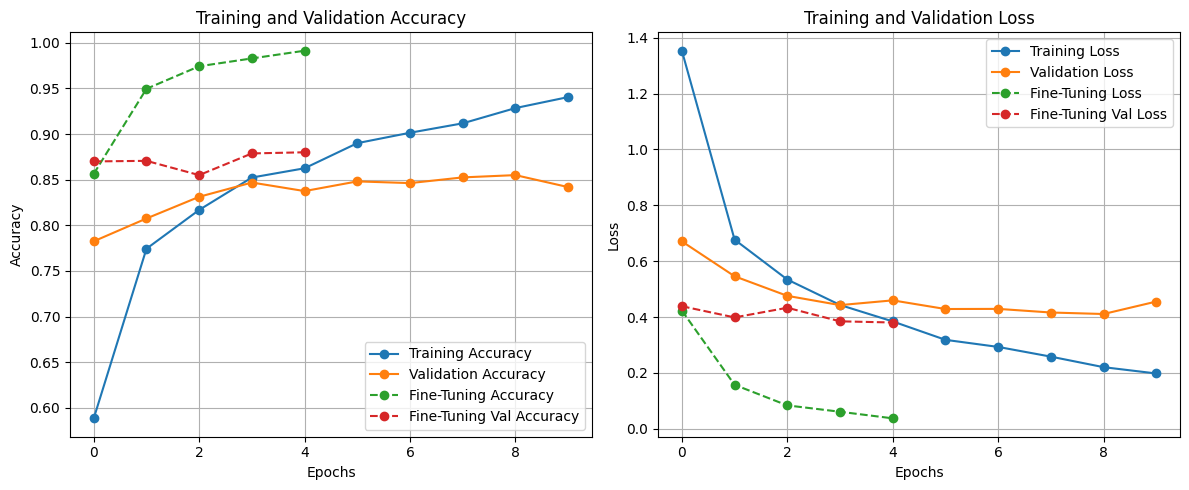

In [7]:
# Testing

loss, accuracy = model.evaluate(test_images, steps=test_images.samples // batch_size, verbose=1)
print(f"Loss : {loss:.4f}, Accuracy : {accuracy:.4f}")

plt.figure(figsize=(12,5))

# Training Accuracy Graph
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], marker="o", label="Training Accuracy")
plt.plot(history.history["val_accuracy"], marker="o", label="Validation Accuracy")

# Also adding fine-tuning data
if 'history_fine' in globals():
    plt.plot(history_fine.history["accuracy"], marker="o", linestyle="dashed", label="Fine-Tuning Accuracy")
    plt.plot(history_fine.history["val_accuracy"], marker="o", linestyle="dashed", label="Fine-Tuning Val Accuracy")

plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Training Loss Graphs
plt.subplot(1,2,2)
plt.plot(history.history["loss"], marker="o", label="Training Loss")
plt.plot(history.history["val_loss"], marker="o", label="Validation Loss")

# Also adding fine-tuning data
if 'history_fine' in globals():
    plt.plot(history_fine.history["loss"], marker="o", linestyle="dashed", label="Fine-Tuning Loss")
    plt.plot(history_fine.history["val_loss"], marker="o", linestyle="dashed", label="Fine-Tuning Val Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step


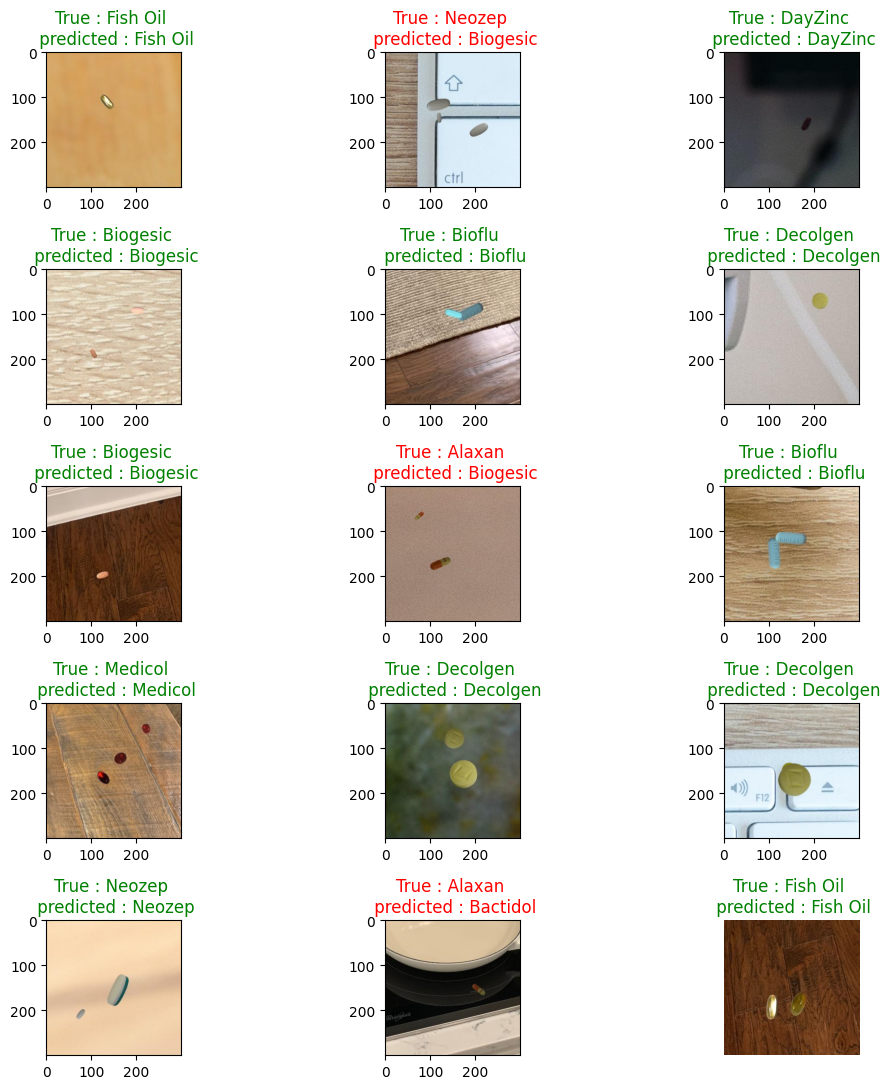

In [8]:
pred = model.predict(test_images, steps=test_images.samples//batch_size)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((value,key) for key,value in labels.items())

pred = [labels[k] for k in pred]

random_index = np.random.randint(0, len(test_df)-1, 15)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(11,11))

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True : {test_df.label.iloc[random_index[i]]} \n predicted : {pred[random_index[i]]}", color=color)

ax.axis("off")
plt.tight_layout()
plt.show()

In [9]:
y_test = list(test_df.label)
print("Length of y_test:", len(y_test))
print("Length of pred:", len(pred))

"""
The reason why pred is shorter: The test_generator might have skipped the last batch.
If the test data is not a multiple of batch_size, the last batch may not be processed.

Example Scenario:
Total test samples (test_df.samples): 2000
Batch size (batch_size): 64
Number of batches processed? → 2000 // 64 = 31 (Not a perfect division, 31 * 64 = 1984 samples are processed, leaving 16 samples missing).

"""



Length of y_test: 2000
Length of pred: 1984


'\nThe reason why pred is shorter: The test_generator might have skipped the last batch.\nIf the test data is not a multiple of batch_size, the last batch may not be processed.\n\nExample Scenario:\nTotal test samples (test_df.samples): 2000\nBatch size (batch_size): 64\nNumber of batches processed? → 2000 // 64 = 31 (Not a perfect division, 31 * 64 = 1984 samples are processed, leaving 16 samples missing).\n\n'

In [10]:
min_length = min(len(y_test), len(pred))
y_test = y_test[:min_length]
pred = pred[:min_length]

In [11]:
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

      Alaxan       0.95      0.82      0.88       205
    Bactidol       0.94      0.74      0.83       200
      Bioflu       0.93      0.90      0.91       192
    Biogesic       0.76      0.84      0.80       201
     DayZinc       0.94      0.89      0.92       208
    Decolgen       0.95      0.86      0.90       186
    Fish Oil       0.96      0.94      0.95       209
    Kremil S       0.63      0.94      0.76       201
     Medicol       0.92      0.94      0.93       208
      Neozep       0.90      0.83      0.86       174

    accuracy                           0.87      1984
   macro avg       0.89      0.87      0.88      1984
weighted avg       0.89      0.87      0.88      1984

